In [1]:
import os
import sys
import warnings

from glob import glob
import random
import datetime
import re
from tqdm import tqdm

import pandas as pd
import numpy as np

from google.cloud import bigquery

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

import gspread
from oauth2client.service_account import ServiceAccountCredentials


from plotnine import *

In [2]:
warnings.filterwarnings('ignore')

In [3]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
font = fm.FontProperties(fname=path, size=9)

NanumGothic


In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)
pd.options.display.float_format = '{:.2f}'.format

In [5]:
def bigquery_to_pandas(query_string) :

    credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json'
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path
    bqclient = bigquery.Client()
    
    b = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
    )
    
    return b

In [6]:
def gs_append(url, credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json', scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']) : 
    
    credentials = ServiceAccountCredentials.from_json_keyfile_name(credential_path, scope)
    
    gc = gspread.authorize(credentials)
    doc = gc.open_by_url(url)
    
    sheet_name = re.search(string = str(doc.get_worksheet(0)), pattern = r"\'(.*)\'").group(0)[1:-1]
    sheet = doc.worksheet(sheet_name)
    
    sheet_content = sheet.get_all_values()
    
    df_ = pd.DataFrame(sheet_content[1:], columns = sheet_content[0])
    
    return df_

In [7]:
def read_bql(file_name) :
    with open(file_name, "r") as f :
        bql = f.read()
    return bql

In [9]:
advicet = bigquery_to_pandas(read_bql("../bql/advicetransaction.bql"))

In [17]:
adorder = bigquery_to_pandas(read_bql("../bql/adorders_lawyer_chk.bql"))
advice = bigquery_to_pandas(read_bql("../bql/advice_chk.bql"))
advicet = bigquery_to_pandas(read_bql("../bql/advicetransaction.bql"))
ga = bigquery_to_pandas(read_bql("../bql/ga_profile_exposure.bql"))
gae = bigquery_to_pandas(read_bql("../bql/ga_search_keyword.bql"))
lawyer = bigquery_to_pandas(read_bql("../bql/lawyer_name.bql"))

In [11]:
keyword = gs_append(url = 'https://docs.google.com/spreadsheets/d/1n9YKC3L9_d4QRKjlDqbHelxw5nC3Fz8hrgbHahOHhxM/edit#gid=0')
keyword.columns = ["type1", "type2", "search_keyword"]

In [12]:
def get_gini(df, val_col, color = "red", plot_tf = True) :
    tmp = df.copy()
    tmp["ratio"] = tmp[val_col] / tmp[val_col].max()
    tmp["rnk"] = tmp.ratio.rank(method = "first")  / tmp.shape[0]
    tmp = tmp.sort_values("rnk")
    tmp["eq_line"] = [i / tmp.shape[0] for i in range(tmp.shape[0])]
    
    lorenz = (tmp.rnk * tmp.shape[0] * (tmp.ratio / tmp.shape[0])).sum()
    tri = ((tmp.rnk * tmp.shape[0]).max() * tmp.rnk.max()) / 2
    
    if plot_tf == True :
        print((
            ggplot(data = tmp) +
            geom_col(mapping = aes(x = "rnk", y = "ratio"), fill = color, alpha = 0.6) +
            geom_line(mapping = aes(x = "rnk", y = "eq_line"), group = 1) +
            theme_bw() +
            theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
        ))
    
    return (tri - lorenz) / tri

In [18]:
ga_ad = pd.merge(ga, adorder[["slug", "ad_tf", "ad_cnt"]], on = "slug", how = "left")
ga_ad.loc[ga_ad.search_keyword.isin(keyword.search_keyword), "mapping"] = 1
ga_ad.loc[~ga_ad.search_keyword.isin(keyword.search_keyword), "mapping"] = 0

ga_ad.search_keyword = ga_ad.search_keyword.str.replace(pat = "~2F", repl = "/")
ga_ad.search_keyword = ga_ad.search_keyword.fillna("")
ga_ad.space_len = ga_ad.search_keyword.str.split(" |/", regex = True).apply(lambda x : len(x))

In [19]:
# 조건1 : 검색어와 검색 결과가 같지 않고(대분야 클릭으로 들어오지 않은) 변호사 이름이 아닌 검색어들
if1 = (ga_ad.search_keyword != ga_ad.expose_reason) & (ga_ad.search_keyword.notna()) & (ga_ad.search_keyword != "") &  (~ga_ad.search_keyword.str.contains("/")) & (~ga_ad.search_keyword.isin(lawyer.name))
# 조건2 : 조건1 + 한단어(뛰어쓰기가 없도록)
if2 = (ga_ad.search_keyword != ga_ad.expose_reason) & (ga_ad.search_keyword.notna()) & (ga_ad.search_keyword != "") & (ga_ad.space_len == 1) & (~ga_ad.search_keyword.str.contains("/")) & (~ga_ad.search_keyword.isin(lawyer.name))
# 조건3 : 조건1에 100개 이상 검색된 결과
if3 = (ga_ad.search_keyword != ga.expose_reason) & (ga_ad.search_keyword.notna()) & (ga_ad.search_keyword != "") &  (~ga_ad.search_keyword.str.contains("/")) & (~ga_ad.search_keyword.isin(lawyer.name))
# 조건4 : 조건2에 100개 이상 검색된 결과
if4 = (ga_ad.search_keyword != ga_ad.expose_reason) & (ga_ad.search_keyword.notna()) & (ga_ad.search_keyword != "") & (ga_ad.space_len == 1) & (~ga_ad.search_keyword.str.contains("/")) & (~ga_ad.search_keyword.isin(lawyer.name))

In [22]:
ga_ad[if3].groupby("search_keyword").slug.count().reset_index()

,search_keyword,slug
0,010 경찰,1
1,11대중과실교통사고,119
2,12대 중대과실 교통사고 피해자,14
3,12대중과실,13
4,17세 의제강간,2
...,...,...
5366,흉기은닉,2
5367,흉터,29
5368,흡연 촬영,17
5369,히요비,4


In [26]:
print(ga_ad[if1].groupby(["search_keyword"]).slug.count().sort_values(ascending = False).shape[0])
print(ga_ad[if2].groupby("search_keyword").slug.count().sort_values(ascending = False).shape[0])
print(ga_ad[if3].groupby("search_keyword").slug.count().reset_index().query("slug > 100").sort_values(by = "slug", ascending = False).shape[0])
print(ga_ad[if4].groupby("search_keyword").slug.count().reset_index().query("slug > 100").sort_values(by = "slug", ascending = False).shape[0])

5371
3064
660
633


In [27]:
ga_ad[if1].groupby("mapping").user_pseudo_id.nunique()


mapping
0.00    8099
1.00    8677
Name: user_pseudo_id, dtype: int64

In [30]:
ga_ad[if1 & (ga_ad.mapping == 1)].groupby("search_keyword").user_pseudo_id.nunique().sort_values(ascending = False).head()

search_keyword
통신매체이용음란죄    350
증여세          268
양도세          183
퇴직금          148
폭행           138
Name: user_pseudo_id, dtype: int64

In [31]:
ga_ad[if1 & (ga_ad.mapping == 0)].groupby("search_keyword").user_pseudo_id.nunique().sort_values(ascending = False).head()

search_keyword
노무사        248
통신매체음란죄    220
부동산        162
성범죄        159
이혼전문변호사    148
Name: user_pseudo_id, dtype: int64

검색어 별 변호사 프로필 노출에 대한 gini 계수

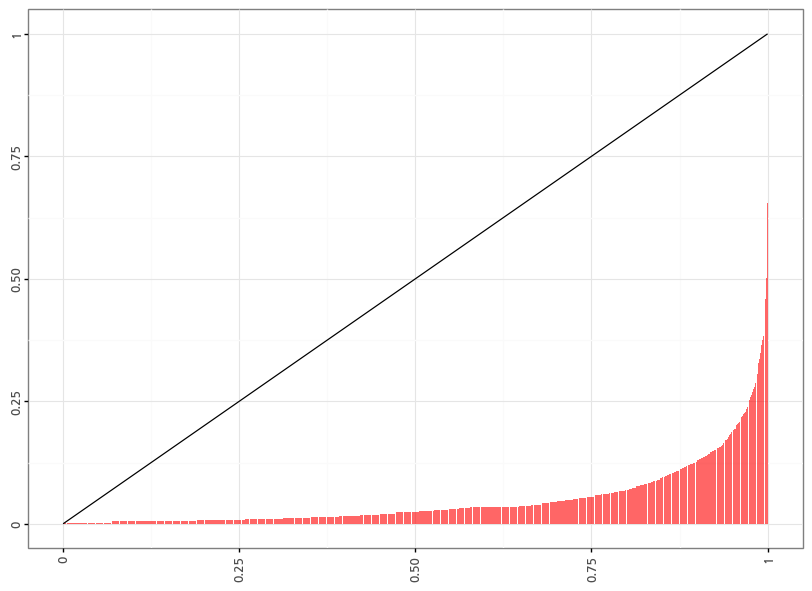

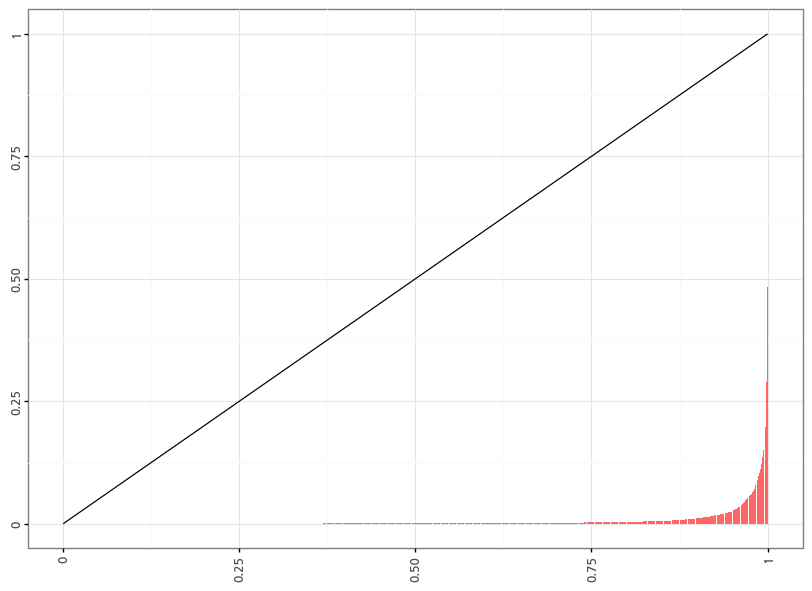

0.9880398303311547

In [33]:
get_gini(ga[if1].groupby("search_keyword").slug.nunique().reset_index(), "slug")
get_gini(ga[if1].groupby("search_keyword").slug.count().reset_index(), "slug")

In [ ]:

get_gini(ga[if2].groupby("search_keyword").slug.nunique().reset_index(), "slug")

get_gini(ga[if2].search_keyword.value_counts().reset_index(), "search_keyword")
get_gini(ga[if3].search_keyword.value_counts().reset_index().query("search_keyword > 100"), "search_keyword")
get_gini(ga[if4].search_keyword.value_counts().reset_index().query("search_keyword > 100"), "search_keyword")

get_gini(ga.groupby("lawyer_id").event_date.count().reset_index(), "event_date")
get_gini(ga.groupby("slug").user_pseudo_id.nunique().reset_index(), "user_pseudo_id")

ga[if1].groupby("slug").event_date.count().sort_values(ascending = False)

get_gini(ga[(if1)].groupby("lawyer_id").event_date.count().reset_index(), "event_date")
get_gini(ga[if2].groupby("lawyer_id").event_date.count().reset_index(), "event_date")

get_gini(ga[(if1)].groupby("slug").event_date.count().reset_index(), "event_date")
get_gini(ga[if2].groupby("slug").event_date.count().reset_index(), "event_date")

### 총 유료 상담 5177건 중에 검색어로 유입된 유료 상담은 1550건 -> 약 30%

In [40]:
advicet.shape[0]

5177

In [39]:
advicet[(advicet.metadata_context == 'category') & (advicet.metadata_extraInfo != advicet.metadata_contextAdditional)].shape[0]

1550

In [35]:
advicet[(advicet.metadata_context == 'category') & (advicet.metadata_extraInfo != advicet.metadata_contextAdditional)].metadata_contextAdditional.value_counts()[:10]

폭행/협박/상해 일반    83
임대차            82
노동/인사          68
디지털 성범죄        60
성폭력/강제추행 등     54
이혼             53
기타 재산범죄        47
교통사고/도주        44
명예훼손/모욕 일반     41
상속             38
Name: metadata_contextAdditional, dtype: int64

In [41]:
for i in advicet[(advicet.metadata_context == 'category') & (advicet.metadata_extraInfo != advicet.metadata_contextAdditional)].metadata_contextAdditional.value_counts()[:10].index :
    print(advicet[advicet.metadata_contextAdditional.fillna("").str.contains(i)].shape[0])

298
373
174
244
220
215
152
96
204
138


분야 별 유료 상담에 대한 변호사 불평등도

임대차


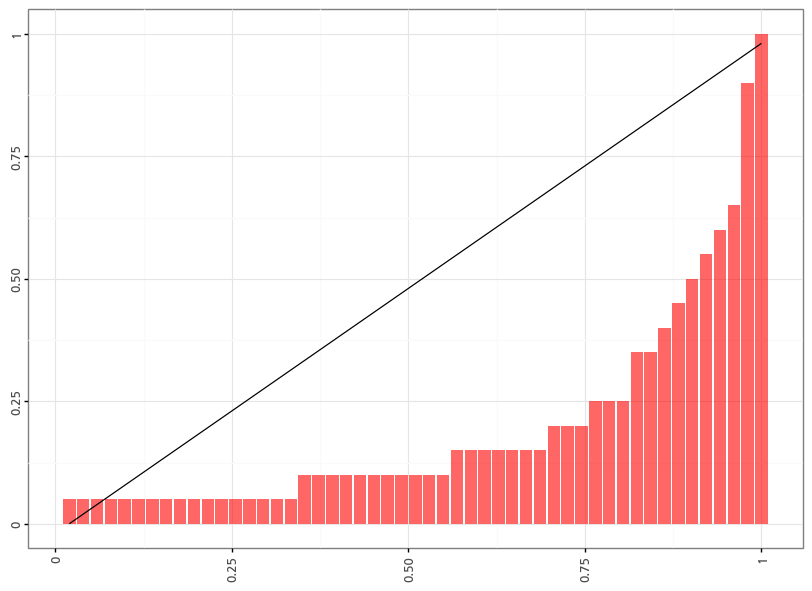


사이버 명예훼손/모욕


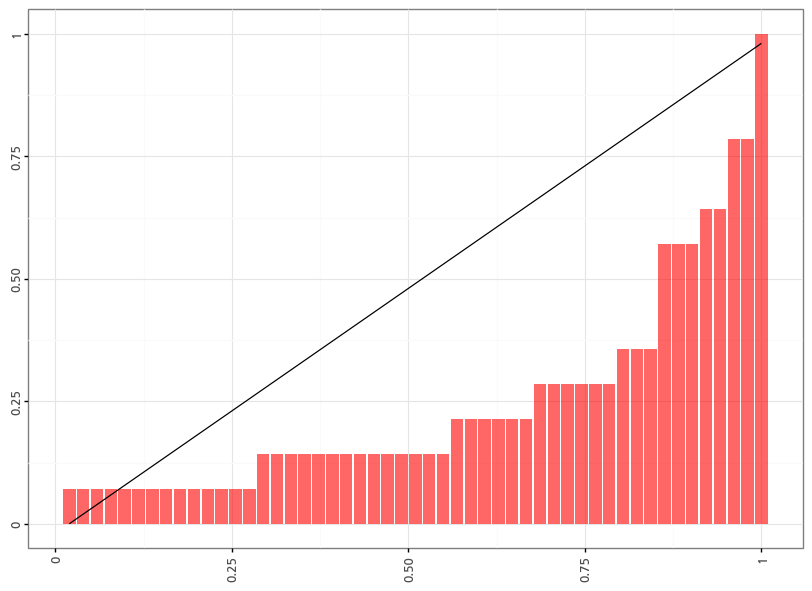


폭행/협박/상해 일반


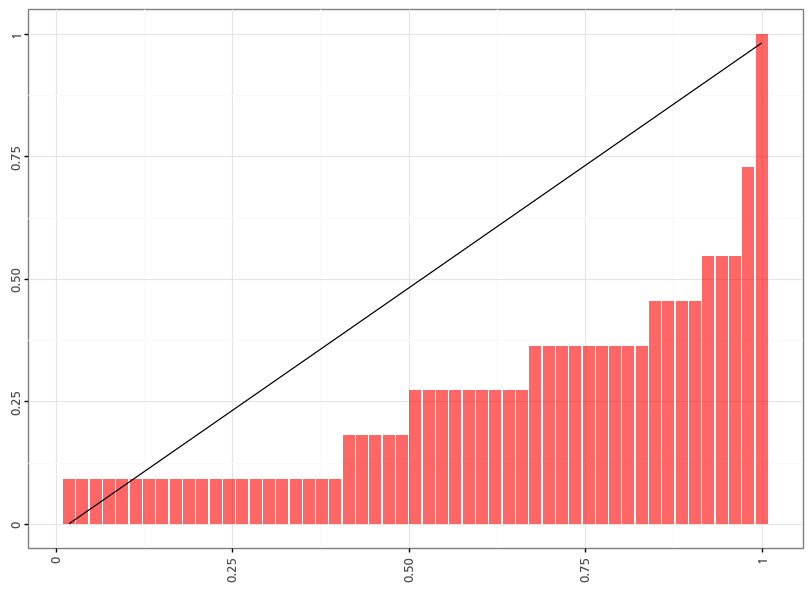


명예훼손/모욕 일반


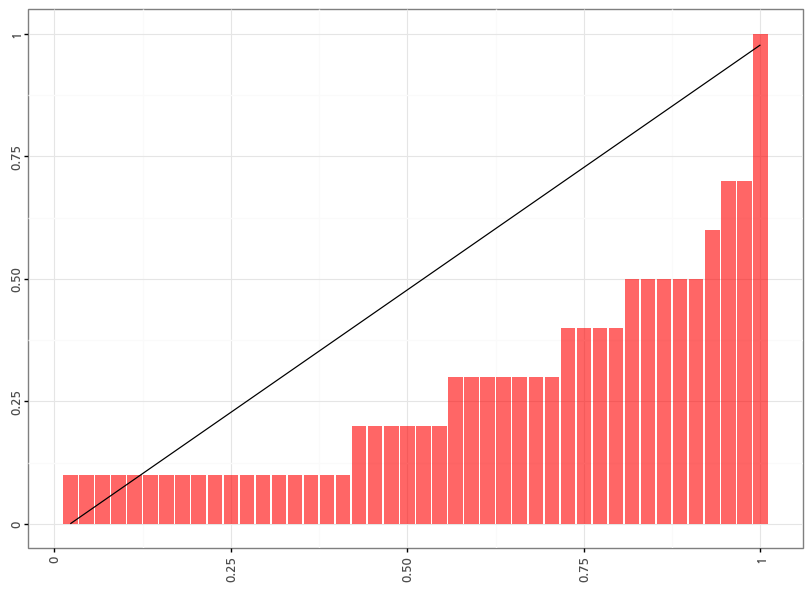


이혼


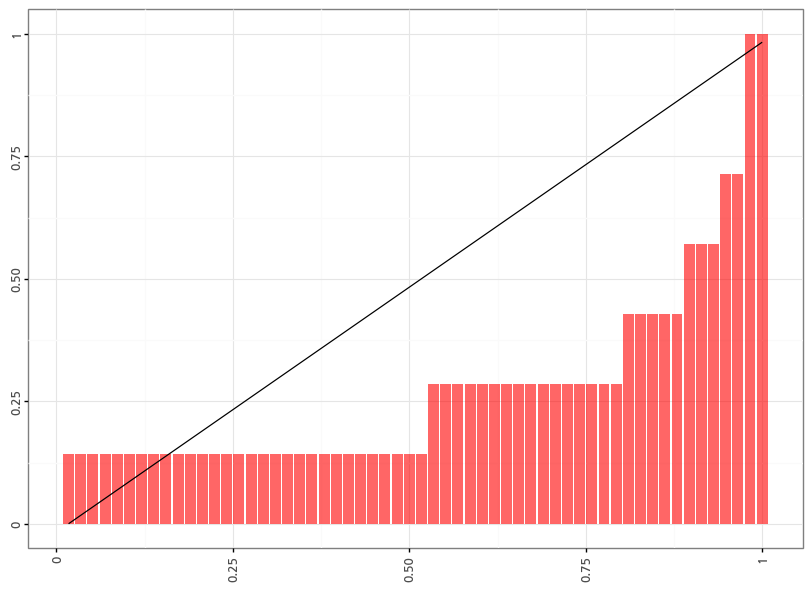


노동/인사


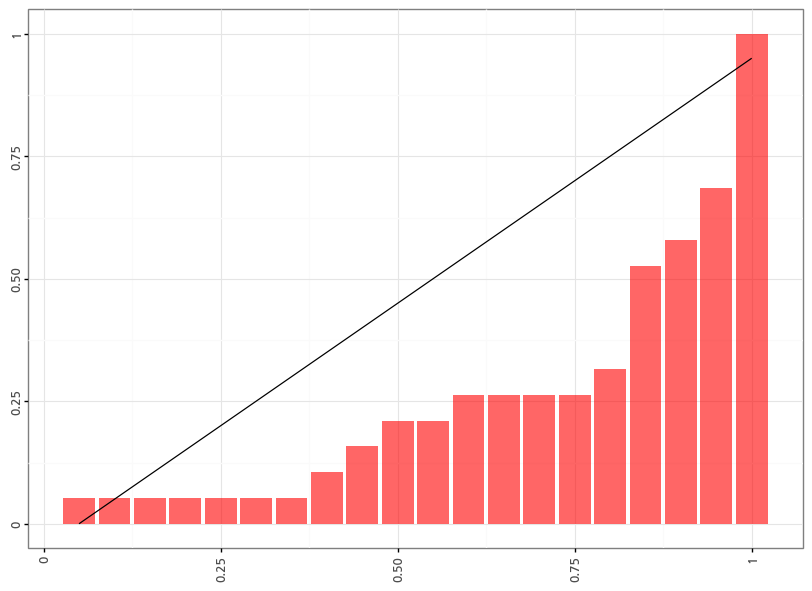


디지털 성범죄


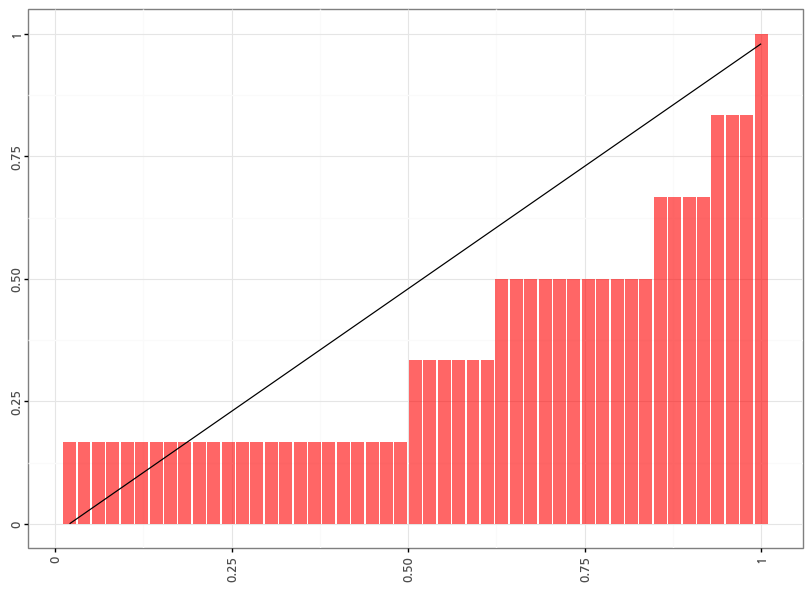


성폭력/강제추행 등


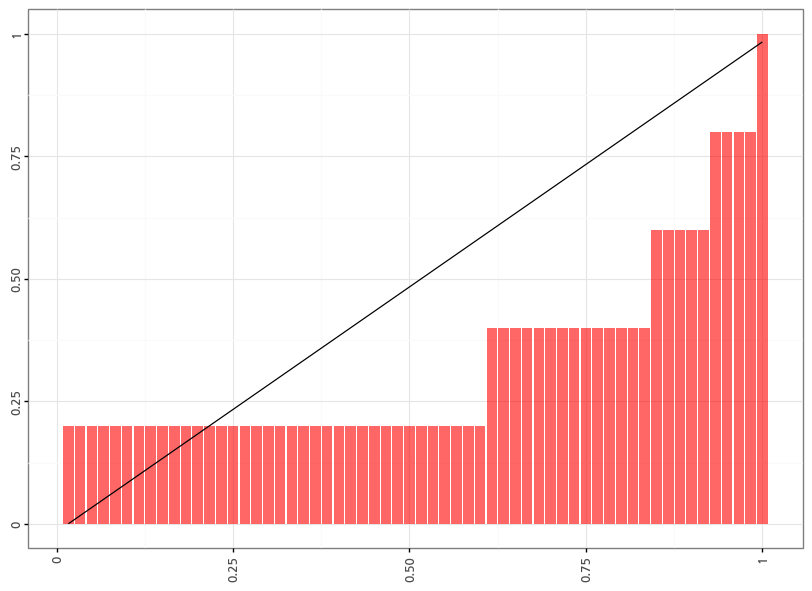


상속


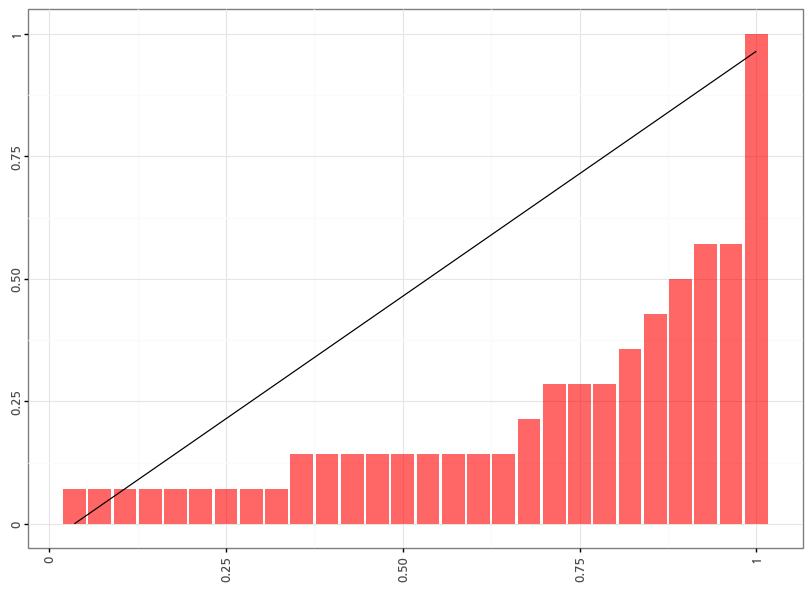


사기/공갈


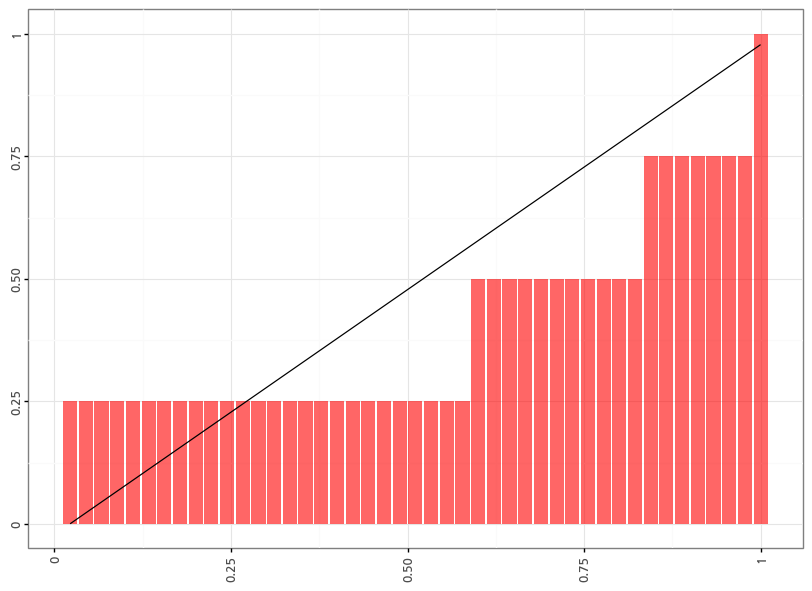

In [49]:
for i in list(advicet[if1].metadata_extraInfo.value_counts()[:10].index) :
    print(i)
    get_gini(advicet[advicet.metadata_extraInfo == i].groupby("slug")._id.count().reset_index(), "_id")

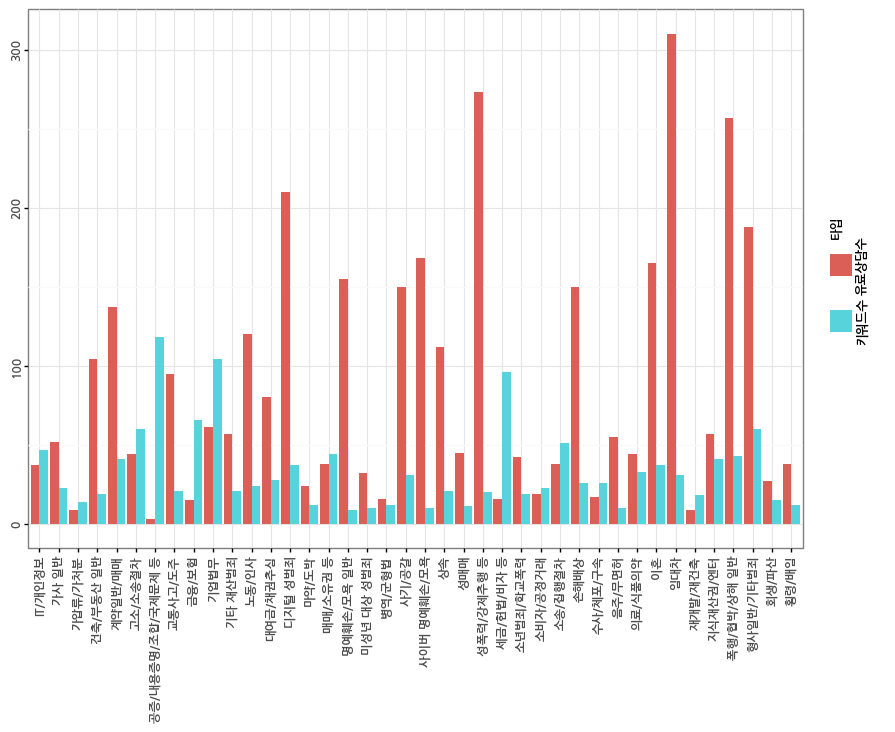

<ggplot: (8775446859234)>

In [45]:

tmp1 = advice.adCategory_name.value_counts().reset_index().assign(tp = "유료상담수")
tmp2 = keyword.groupby("type2").search_keyword.count().reset_index().assign(tp = "키워드수")

tmp1.columns = ["분야", "카운트", "타입"]
tmp2.columns = ["분야", "카운트", "타입"]

(
    ggplot(data = pd.concat([tmp1[tmp1.분야 != '기타'], tmp2], axis = 0)) +
    geom_col(mapping = aes(x = "분야", y = "카운트", fill = "타입"), position = "dodge") +
    theme_bw() +
    theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
)
